In [201]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

In [202]:
yrs = np.arange(1950,2100,1)

In [203]:
def effect_SST(sst_delta, R, DIC, pCO2):
    
    dpCO2 = 0.04*pCO2*sst_delta
    delDIC = (DIC/pCO2) * dpCO2/R
    
    #for a positive increase in sst, positive DIC
    dDIC_T = 1 *delDIC
    return dDIC_T
    
def effect_MLD(mld_delta, grad_dDICdz,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio):
    #dic
    dDIC_MLD = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
    #iron (ecosystem)
    dFe = mld_delta *  grad_dFedz #dFe = dMLD x dFe/dz 
    #print(dFe)
    dBioDIC_MLD = -1 * dmudFe * dFe * mu_L * diatconc * 365.25 * efratio #dDIC = -dmu/dFe x dFe x mu_L x DIA x dtime  
    
    return dDIC_MLD, dBioDIC_MLD



def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, \
              diatconc, MLD, efratio = 0.5, SO_area = 4.67e13 ):

    dDIC_OT = ot_delta * 1e6 * grad_DIC_surfdeep / 1000*31557600    ## in mols to surface
    
    #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dBioDIC_OT = dDICv * ot_delta * 1e6 * 1000*31557600*0.000001 #in mols extra DIC to surface    
    dDIC_OT = dDIC_OT/SO_area/MLD*1000
    dBioDIC_OT = dBioDIC_OT/SO_area/MLD*1000 ## mmols/m3 at surface
    
    return dDIC_OT, dBioDIC_OT


## ukesm SST, MLD, OT, CFLX trends

In [204]:
sst_ukesm_1A = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/SST_ukesm_1A.nc')
sst_ukesm_1B = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/SST_ukesm_1B.nc')

mld_ukesm_1A = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/somxl010_ukesm_1A.nc')
mld_ukesm_1B = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/somxl010_ukesm_1B.nc')

Cflx_ukesm_1A = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/CflxTS_ukesm_1A_SO.nc')
Cflx_ukesm_1B = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/CflxTS_ukesm_1B_SO.nc')

def make_yearlist(yrst, yrend, tscen, \
                  tdir = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/max_OT_s50/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        ty = f'{tdir}/seas_OT_{yr}_{tscen}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

ot_ukesm_1A = xr.open_mfdataset(make_yearlist(1950,2099,'1A'))
ot_ukesm_1B = xr.open_mfdataset(make_yearlist(1950,2099,'1B'))

In [205]:
sst_1A = sst_ukesm_1A.tos.groupby('time_counter.year').mean().values
sst_1B = sst_ukesm_1B.tos.groupby('time_counter.year').mean().values
mld_1A = mld_ukesm_1A.somxl010.groupby('time_counter.year').mean().values
mld_1B = mld_ukesm_1B.somxl010.groupby('time_counter.year').mean().values
ot_1A = ot_ukesm_1A.max_OT_yr.groupby('time_counter.year').mean().values
ot_1B = ot_ukesm_1B.max_OT_yr.groupby('time_counter.year').mean().values

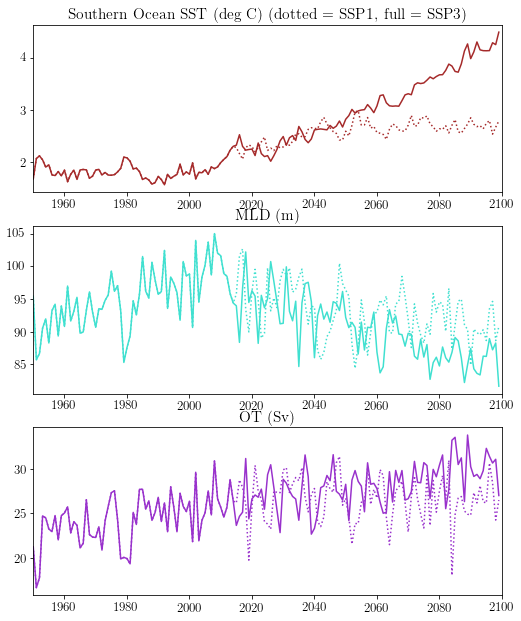

In [206]:
sst_col = 'brown'
mld_col = 'turquoise'
ot_col = 'darkorchid'
eco_col = 'limegreen'

fact = 0.7
fig, axs = plt.subplots(3,1, figsize=(12*fact, 15*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(yrs,sst_1A, linestyle = ':', color = sst_col)
axs[0].plot(yrs,sst_1B, linestyle = '-', color = sst_col)

axs[1].plot(yrs,mld_1A, linestyle = ':', color = mld_col)
axs[1].plot(yrs,mld_1B, linestyle = '-', color = mld_col)

axs[2].plot(yrs,ot_1A, linestyle = ':', color = ot_col)
axs[2].plot(yrs,ot_1B, linestyle = '-', color = ot_col)


tits = ['Southern Ocean SST (deg C) (dotted = SSP1, full = SSP3)',
       'MLD (m)',\
       'OT (Sv)']
for i in range(0,3):
    axs[i].set_title(tits[i])
    axs[i].set_xlim([1950,2100])

## glodap and medusa carbonate chemistry

In [207]:
def make_yearlist_glodap_cchem(scen):
    yrs = np.arange(1950,2100,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'./data/cchem-param-glodap_sdp_scen-{scen}-{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def make_yearlist_medusa_cchem(scen):
    yrs = np.arange(1950,2100,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'./data/cchem-param-medusa_scen-{scen}-{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

glodap_cchem_1A = xr.open_mfdataset(make_yearlist_glodap_cchem('1A'))
glodap_cchem_1B = xr.open_mfdataset(make_yearlist_glodap_cchem('1B'))
medusa_cchem_1A = xr.open_mfdataset(make_yearlist_medusa_cchem('1A'))
medusa_cchem_1B = xr.open_mfdataset(make_yearlist_medusa_cchem('1B'))




In [208]:
glodap_DIC_1A = glodap_cchem_1A.mn_DIC.groupby('time_counter.year').mean().values[:,0]
glodap_DIC_1B = glodap_cchem_1B.mn_DIC.groupby('time_counter.year').mean().values[:,0]
medusa_DIC_1A = medusa_cchem_1A.mn_DIC.groupby('time_counter.year').mean().values[:,0]
medusa_DIC_1B = medusa_cchem_1B.mn_DIC.groupby('time_counter.year').mean().values[:,0]

glodap_TA_1A = glodap_cchem_1A.mn_TA.groupby('time_counter.year').mean().values[:,0]
glodap_TA_1B = glodap_cchem_1B.mn_TA.groupby('time_counter.year').mean().values[:,0]
medusa_TA_1A = medusa_cchem_1A.mn_TA.groupby('time_counter.year').mean().values[:,0]
medusa_TA_1B = medusa_cchem_1B.mn_TA.groupby('time_counter.year').mean().values[:,0]

glodap_dDICdz_1A = glodap_cchem_1A.grad_dDICdz.groupby('time_counter.year').mean().values[:,0]
glodap_dDICdz_1B = glodap_cchem_1B.grad_dDICdz.groupby('time_counter.year').mean().values[:,0]
medusa_dDICdz_1A = medusa_cchem_1A.grad_dDICdz.groupby('time_counter.year').mean().values[:,0]
medusa_dDICdz_1B = medusa_cchem_1B.grad_dDICdz.groupby('time_counter.year').mean().values[:,0]

glodap_dDICsd_1A = glodap_cchem_1A.grad_DIC_surfdeep.groupby('time_counter.year').mean().values[:,0]
glodap_dDICsd_1B = glodap_cchem_1B.grad_DIC_surfdeep.groupby('time_counter.year').mean().values[:,0]
medusa_dDICsd_1A = medusa_cchem_1A.grad_DIC_surfdeep.groupby('time_counter.year').mean().values[:,0]
medusa_dDICsd_1B = medusa_cchem_1B.grad_DIC_surfdeep.groupby('time_counter.year').mean().values[:,0]

glodap_Revfact_1A = glodap_cchem_1A.mn_Revfact.groupby('time_counter.year').mean().values[:,0]
glodap_Revfact_1B = glodap_cchem_1B.mn_Revfact.groupby('time_counter.year').mean().values[:,0]
medusa_Revfact_1A = medusa_cchem_1A.mn_Revfact.groupby('time_counter.year').mean().values[:,0]
medusa_Revfact_1B = medusa_cchem_1B.mn_Revfact.groupby('time_counter.year').mean().values[:,0]

glodap_pCO2_1A = glodap_cchem_1A.mn_pCO2.groupby('time_counter.year').mean().values[:,0]
glodap_pCO2_1B = glodap_cchem_1B.mn_pCO2.groupby('time_counter.year').mean().values[:,0]
medusa_pCO2_1A = medusa_cchem_1A.mn_pCO2.groupby('time_counter.year').mean().values[:,0]
medusa_pCO2_1B = medusa_cchem_1B.mn_pCO2.groupby('time_counter.year').mean().values[:,0]

## biology

In [209]:
def make_yearlist_bio(yrst, yrend, scen):

    tdir = '/gpfs/home/mep22dku/scratch/BOE-SOcarbon/data/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]

        t2 = glob.glob(f'{tdir}biol-param-medusa_scen-{scen}-{yr}.nc')
        ylist.append(t2[0])
        
    return ylist

    
medusa_bio_1A = xr.open_mfdataset(make_yearlist_bio(1950,2099,'1A'))
medusa_bio_1B = xr.open_mfdataset(make_yearlist_bio(1950,2099,'1B'))

w = xr.open_dataset('./data/BOE-inputs/BOE-INPUT-OBS.nc')

In [210]:
medusa_dFedz_1A = medusa_bio_1A.dmudFe.groupby('time_counter.year').mean().values[:,0]
medusa_dFedz_1B = medusa_bio_1B.dmudFe.groupby('time_counter.year').mean().values[:,0]

medusa_diat_1A = medusa_bio_1A.diatconc.groupby('time_counter.year').mean().values[:,0]
medusa_diat_1B = medusa_bio_1B.diatconc.groupby('time_counter.year').mean().values[:,0]

medusa_dFesd_1A = medusa_bio_1A.grad_dFev.groupby('time_counter.year').mean().values[:,0]
medusa_dFesd_1B = medusa_bio_1B.grad_dFev.groupby('time_counter.year').mean().values[:,0]

glodap_dFedz_1A = np.zeros_like(medusa_dFedz_1A)
glodap_dFedz_1A[:] = 0.000528
glodap_dFedz_1B = np.zeros_like(medusa_dFedz_1A)
glodap_dFedz_1B[:] = 0.000528

glodap_diat_1A = np.zeros_like(medusa_dFedz_1A)
glodap_diat_1A[:] = 1.59675
glodap_diat_1B = np.zeros_like(medusa_dFedz_1A)
glodap_diat_1B[:] = 1.59675

glodap_dFesd_1A = np.zeros_like(medusa_dFedz_1A)
glodap_dFesd_1A[:]= 0.226392
glodap_dFesd_1B = np.zeros_like(medusa_dFedz_1A)
glodap_dFesd_1B[:]= 0.226392



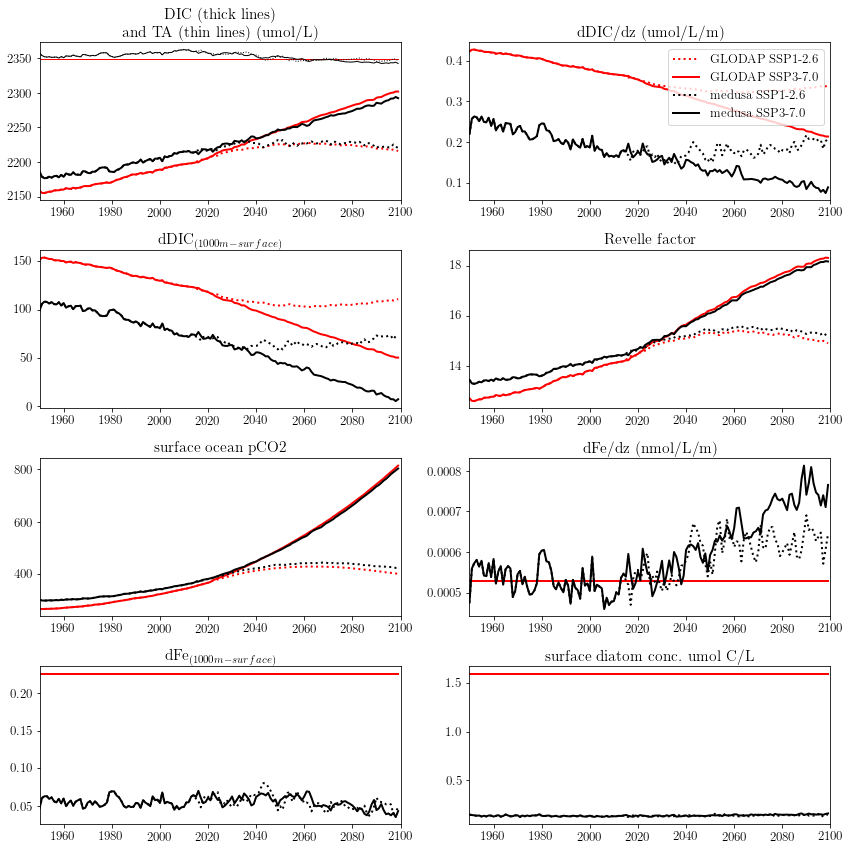

In [211]:

fact = 1

fig, axs = plt.subplots(4,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(yrs, glodap_DIC_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[0].plot(yrs, glodap_DIC_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[0].plot(yrs, glodap_TA_1A, 'r:', linewidth = 1, label = 'GLODAP SSP1-2.6 (TA)')
axs[0].plot(yrs, glodap_TA_1B, 'r-', linewidth = 1, label = 'GLODAP SSP3-7.0 (TA)')

axs[0].plot(yrs, medusa_DIC_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[0].plot(yrs, medusa_DIC_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')
axs[0].plot(yrs, medusa_TA_1A, 'k:', linewidth = 1, label = 'medusa SSP1-2.6 (TA)')
axs[0].plot(yrs, medusa_TA_1B, 'k-', linewidth = 1, label = 'medusa SSP3-7.0 (TA)')

ind = 1
axs[ind].plot(yrs, glodap_dDICdz_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_dDICdz_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_dDICdz_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_dDICdz_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 2
axs[ind].plot(yrs, glodap_dDICsd_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_dDICsd_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_dDICsd_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_dDICsd_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 3
axs[ind].plot(yrs, glodap_Revfact_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_Revfact_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_Revfact_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_Revfact_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 4
axs[ind].plot(yrs, glodap_pCO2_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_pCO2_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_pCO2_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_pCO2_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 5
axs[ind].plot(yrs, glodap_dFedz_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_dFedz_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_dFedz_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_dFedz_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 6
axs[ind].plot(yrs, glodap_dFesd_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_dFesd_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_dFesd_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_dFesd_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 7
axs[ind].plot(yrs, glodap_diat_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_diat_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_diat_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_diat_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

axs[1].legend(loc = 'best')

tits = ['DIC (thick lines) \n and TA (thin lines) (umol/L)',
       'dDIC/dz (umol/L/m)', 'dDIC$_{(1000m-surface)}$',\
       'Revelle factor', 'surface ocean pCO2', 'dFe/dz (nmol/L/m)', \
       'dFe$_{(1000m-surface)}$', 'surface diatom conc. umol C/L']
for i in range(0,8):
    axs[i].set_title(tits[i])
    axs[i].set_xlim([1950,2100])
    
    
plt.tight_layout()

### ok now the effects

In [212]:
def get_effects(T_ts, RevelleFact, DIC, pco2,\
               MLD_ts, grad_DIC_MLD, grad_fe_MLD, diat, \
               OT_ts,  grad_DIC_OT, grad_fe_OT):

    #constants
    efratio = 0.5
    dmudFe = 0.59; 
    muL = 0.438275
    ##initialize
    ts_OT_effect = np.zeros_like(pco2)
    ts_MLD_effect = np.zeros_like(pco2)
    ts_T_effect = np.zeros_like(pco2)
    ts_ECO_effect = np.zeros_like(pco2)
    ts_DIC_effect = np.zeros_like(pco2)

    ts_OT_effect_cum = np.zeros_like(pco2)
    ts_MLD_effect_cum = np.zeros_like(pco2)
    ts_T_effect_cum = np.zeros_like(pco2)
    ts_ECO_effect_cum = np.zeros_like(pco2)
    ts_DIC_effect_cum = np.zeros_like(pco2)


    for i in range(1,150):

        sst_delta = T_ts[i]-T_ts[i-1]
        dDIC_T = effect_SST(sst_delta, RevelleFact[i-1], DIC[i-1], pco2[i-1])
        ts_T_effect[i] = dDIC_T

        mld_delta = MLD_ts[i] - MLD_ts[i-1] 
        diatconc = diat[i-1]
        
        dDIC_MLD, dBioDIC_MLD = effect_MLD(mld_delta, grad_DIC_MLD[i-1],\
                    grad_fe_MLD[i-1], dmudFe, muL, diatconc, efratio)
        ts_MLD_effect[i] = dDIC_MLD

        ot_delta = OT_ts[i] - OT_ts[i-1]
        dDIC_OT, dBioDIC_OT = effect_OT(ot_delta,grad_DIC_OT[i-1], \
                                    dmudFe, grad_fe_OT[i-1], muL, \
                  diatconc, MLD_ts[i], efratio, SO_area = 4.67e13 )
        
        ts_OT_effect[i] = dDIC_OT
        ts_ECO_effect[i] = dBioDIC_MLD + dBioDIC_OT
        ts_DIC_effect[i] = DIC[i] - DIC[i-1]

    for i in range(1,150):

        ts_T_effect_cum[i] = ts_T_effect[i] + ts_T_effect_cum[i-1]
        ts_MLD_effect_cum[i] = ts_MLD_effect[i] + ts_MLD_effect_cum[i-1]
        ts_OT_effect_cum[i] = ts_OT_effect[i] + ts_OT_effect_cum[i-1]
        ts_ECO_effect_cum[i] = ts_ECO_effect[i] + ts_ECO_effect_cum[i-1]
        ts_DIC_effect_cum[i] = ts_DIC_effect[i] + ts_DIC_effect_cum[i-1]

    return ts_T_effect, ts_MLD_effect, ts_OT_effect, ts_ECO_effect, ts_DIC_effect,\
    ts_T_effect_cum, ts_MLD_effect_cum, ts_OT_effect_cum, ts_ECO_effect_cum, ts_DIC_effect_cum






In [213]:
def zbastli_zvlast(ts1, ts2, sot, syr = 2000):
    sin = syr-1950
    sotc = sot-1950
    #propc = np.copy(ts1)
    ts1c = savgol(ts1[sin:-1])
    ts2c = savgol(ts2[sin:-1])
    #propc[0:sin] = np.nan
    propc = np.copy(ts1)
    propc[sin:-1] = ts1c/ts2c
    propc[0:sotc] = np.nan
    
    return propc

def zbastli(prop, sot, syr = 2000):
    sin = syr-1950
    sotc = sot-1950
    propc = np.copy(prop)
    medusa_sg = savgol(prop[sin:-1])
    propc[0:sin] = np.nan
    propc[sin:-1] = medusa_sg
    propc[0:sotc] = np.nan
    
    return propc

from scipy import signal

def savgol(x):
    tx = signal.savgol_filter(x, 11, polyorder = 2, \
            deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
    return tx


## 

## get effect sizes for glodap, glodapvul (exaggerated TS) and medusa

In [214]:
ts_T_effect_glodap_1A, ts_MLD_effect_glodap_1A, ts_OT_effect_glodap_1A,\
ts_ECO_effect_glodap_1A, ts_DIC_effect_glodap_1A,\
ts_T_effect_glodap_1A_cum, ts_MLD_effect_glodap_1A_cum,\
ts_OT_effect_glodap_1A_cum, ts_ECO_effect_glodap_1A_cum, ts_DIC_effect_glodap_1A_cum = \
get_effects(sst_1A, glodap_Revfact_1A, glodap_DIC_1A, glodap_pCO2_1A,\
mld_1A, glodap_dDICdz_1A, glodap_dFedz_1A, glodap_diat_1A, \
ot_1A,  glodap_dDICsd_1A, glodap_dFesd_1A)


ts_T_effect_glodap_1B, ts_MLD_effect_glodap_1B, ts_OT_effect_glodap_1B,\
ts_ECO_effect_glodap_1B, ts_DIC_effect_glodap_1B,\
ts_T_effect_glodap_1B_cum, ts_MLD_effect_glodap_1B_cum,\
ts_OT_effect_glodap_1B_cum, ts_ECO_effect_glodap_1B_cum, ts_DIC_effect_glodap_1B_cum = \
get_effects(sst_1B, glodap_Revfact_1B, glodap_DIC_1B, glodap_pCO2_1B,\
mld_1B, glodap_dDICdz_1B, glodap_dFedz_1B, glodap_diat_1B, \
ot_1B,  glodap_dDICsd_1B, glodap_dFesd_1B)

ts_T_effect_medusa_1A, ts_MLD_effect_medusa_1A, ts_OT_effect_medusa_1A,\
ts_ECO_effect_medusa_1A, ts_DIC_effect_medusa_1A,\
ts_T_effect_medusa_1A_cum, ts_MLD_effect_medusa_1A_cum,\
ts_OT_effect_medusa_1A_cum, ts_ECO_effect_medusa_1A_cum, ts_DIC_effect_medusa_1A_cum = \
get_effects(sst_1A, medusa_Revfact_1A, medusa_DIC_1A, medusa_pCO2_1A,\
mld_1A, medusa_dDICdz_1A, medusa_dFedz_1A, medusa_diat_1A, \
ot_1A,  medusa_dDICsd_1A, medusa_dFesd_1A)


ts_T_effect_medusa_1B, ts_MLD_effect_medusa_1B, ts_OT_effect_medusa_1B,\
ts_ECO_effect_medusa_1B, ts_DIC_effect_medusa_1B,\
ts_T_effect_medusa_1B_cum, ts_MLD_effect_medusa_1B_cum,\
ts_OT_effect_medusa_1B_cum, ts_ECO_effect_medusa_1B_cum, ts_DIC_effect_medusa_1B_cum = \
get_effects(sst_1B, medusa_Revfact_1B, medusa_DIC_1B, medusa_pCO2_1B,\
mld_1B, medusa_dDICdz_1B, medusa_dFedz_1B, medusa_diat_1B, \
ot_1B,  medusa_dDICsd_1B, medusa_dFesd_1B)

ts_T_effect_glodapvul_1A, ts_MLD_effect_glodapvul_1A, ts_OT_effect_glodapvul_1A,\
ts_ECO_effect_glodapvul_1A, ts_DIC_effect_glodapvul_1A,\
ts_T_effect_glodapvul_1A_cum, ts_MLD_effect_glodapvul_1A_cum,\
ts_OT_effect_glodapvul_1A_cum, ts_ECO_effect_glodapvul_1A_cum, ts_DIC_effect_glodapvul_1A_cum = \
get_effects(sst_1A, glodap_Revfact_1A, glodap_DIC_1A, glodap_pCO2_1A,\
mld_1A, glodap_dDICdz_1A*2, glodap_dFedz_1A, glodap_diat_1A, \
ot_1A,  glodap_dDICsd_1A+100, glodap_dFesd_1A)


ts_T_effect_glodapvul_1B, ts_MLD_effect_glodapvul_1B, ts_OT_effect_glodapvul_1B,\
ts_ECO_effect_glodapvul_1B, ts_DIC_effect_glodapvul_1B,\
ts_T_effect_glodapvul_1B_cum, ts_MLD_effect_glodapvul_1B_cum,\
ts_OT_effect_glodapvul_1B_cum, ts_ECO_effect_glodapvul_1B_cum, ts_DIC_effect_glodapvul_1B_cum = \
get_effects(sst_1B, glodap_Revfact_1B, glodap_DIC_1B, glodap_pCO2_1B,\
mld_1B, glodap_dDICdz_1B*2, glodap_dFedz_1B, glodap_diat_1B, \
ot_1B,  glodap_dDICsd_1B+100, glodap_dFesd_1B)


In [215]:
# plt.rcParams.update({'font.size': 13})
# font = {'family' : 'normal',
# 'weight' : 'normal',
# 'size'   : 13}
# plt.rcParams['text.usetex'] = True
# plt.rc('font', **font)


# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec


# sst_col = 'tomato'#'#e6194B'#'r'
# ot_col = 'navy'#'#9A6324'#'#37323d'#'#2c3438'
# mld_col = 'skyblue'#'#4363d8'#'b'#'#34abeb'
# eco_col = 'teal'#'#66b54c'#'#5f8a1e'
# tot_col = 'y'

# fact = 1.5
# # Create the figure with specified size in inches
# fig = plt.figure(figsize=(7*fact, 3.5*fact))

# # Set up GridSpec with 2 rows and 2 columns, with different height ratios
# gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[4, 1])

# # Create four subplots
# # Top two subplots
# ax3 = fig.add_subplot(gs[0, 0])
# ax4 = fig.add_subplot(gs[0, 1])

# # Bottom two subplots
# ax1 = fig.add_subplot(gs[1, 0])
# ax2 = fig.add_subplot(gs[1, 1])


# ax3.set_title('SSP 1-2.6')
# ax4.set_title('SSP 3-7.0')

# ax3.plot(yrs, ts_T_effect_medusa_1A_cum, color = sst_col, alpha = 0.2)
# ax3.plot(yrs, savgol(ts_T_effect_medusa_1A_cum), color = sst_col, label = 'DIC change due to SST')
# ax3.plot(yrs, ts_MLD_effect_medusa_1A_cum, color = mld_col, alpha = 0.2)
# ax3.plot(yrs, savgol(ts_MLD_effect_medusa_1A_cum), color = mld_col, label = 'DIC change due to MLD')
# ax3.plot(yrs, ts_OT_effect_medusa_1A_cum, color = ot_col, alpha = 0.2 )
# ax3.plot(yrs, savgol(ts_OT_effect_medusa_1A_cum), color = ot_col, label = 'DIC change due to MOC')
# ax3.plot(yrs, ts_ECO_effect_medusa_1A_cum, color = eco_col, alpha = 0.2 )
# ax3.plot(yrs, savgol(ts_ECO_effect_medusa_1A_cum), color = eco_col, label = 'DIC change cumulative')
# ts_tot_effect_1A_cum = ts_T_effect_medusa_1A_cum + ts_MLD_effect_medusa_1A_cum + \
# ts_OT_effect_medusa_1A_cum + ts_ECO_effect_medusa_1A_cum
# ax3.plot(yrs, ts_tot_effect_1A_cum, color = tot_col, alpha = 0.2, linewidth = 1)
# ax3.plot(yrs, savgol(ts_tot_effect_1A_cum), color = tot_col, linewidth = 2)
# ax3.plot(yrs, ts_DIC_effect_medusa_1A_cum, color = 'grey', alpha = 0.2,  label = 'DIC change medusa, 1A')
# ax3.plot(yrs, savgol(ts_DIC_effect_medusa_1A_cum), 'k', alpha = 1, label = 'DIC change cumulative, 1A')

# ax4.plot(yrs, ts_T_effect_medusa_1B_cum, color = sst_col, alpha = 0.2)
# ax4.plot(yrs, savgol(ts_T_effect_medusa_1B_cum), color = sst_col, label = 'SST')
# ax4.plot(yrs, ts_MLD_effect_medusa_1B_cum, color = mld_col, alpha = 0.2)
# ax4.plot(yrs, savgol(ts_MLD_effect_medusa_1B_cum), color = mld_col, label = 'MLD')
# ax4.plot(yrs, ts_OT_effect_medusa_1B_cum, color = ot_col, alpha = 0.2 )
# ax4.plot(yrs, savgol(ts_OT_effect_medusa_1B_cum), color = ot_col, label = 'MOC')
# ax4.plot(yrs, ts_ECO_effect_medusa_1B_cum, color = eco_col, alpha = 0.2 )
# ax4.plot(yrs, savgol(ts_ECO_effect_medusa_1B_cum), color = eco_col, label = 'ECO')
# ts_tot_effect_1B_cum = ts_T_effect_medusa_1B_cum + ts_MLD_effect_medusa_1B_cum + \
# ts_OT_effect_medusa_1B_cum + ts_ECO_effect_medusa_1B_cum
# ax4.plot(yrs, ts_tot_effect_1B_cum, color = tot_col, alpha = 0.2, linewidth = 1)
# ax4.plot(yrs, savgol(ts_tot_effect_1B_cum), color = tot_col, linewidth = 2, label = 'total')
# ax4.plot(yrs, ts_DIC_effect_medusa_1B_cum, color = 'grey', alpha = 0.2,  )
# ax4.plot(yrs, savgol(ts_DIC_effect_medusa_1B_cum), 'k', alpha = 1, label = 'surface DIC change')


# ax3.set_xlim([1950,2100])
# ax4.set_xlim([1950,2100])
# ax3.set_xticks(np.arange(1950,2150,50))
# ax4.set_xticks(np.arange(1950,2150,50))
# ax1.set_xticks(np.arange(1950,2150,50))
# ax2.set_xticks(np.arange(1950,2150,50))
# ax3.set_xticklabels([])
# ax4.set_xticklabels([])



# ax3.text(0.10, 0.91, 'a)', transform=ax3.transAxes, ha='right', va='top')
# ax4.text(0.10, 0.91, 'b)', transform=ax4.transAxes, ha='right', va='top')


# ax4.legend(bbox_to_anchor = [0.58,1], fontsize = 11)
# ax3.tick_params(axis="x", direction="out", length=1, width=1, color="turquoise")
# ax4.tick_params(axis="x", direction="out", length=1, width=1, color="turquoise")


# ax3.grid(alpha = 0.5)
# ax4.grid(alpha = 0.5)
# ax3.set_ylabel('$\mu$mol DIC L$^{-1}$')


# ####
# # Set titles for clarity
# ax1.set_title('')
# ax2.set_title('')
# ax1.tick_params(axis="x", direction="out", length=1, width=1, color="turquoise")
# ax2.tick_params(axis="x", direction="out", length=1, width=1, color="turquoise")
# ax1.grid(alpha = 0.5)
# ax2.grid(alpha = 0.5)
# ax1.set_xlim([1950,2100])
# ax2.set_xlim([1950,2100])

# ts_effect_1A = (ts_tot_effect_1A_cum)/(ts_DIC_effect_medusa_1A_cum)*100
# ts_effect_1A_s = savgol(ts_tot_effect_1A_cum)/savgol(ts_DIC_effect_medusa_1A_cum)*100
# ts_effect_1A[0:40] = np.nan
# ts_effect_1A_s[0:40] = np.nan

# ax1.plot(yrs, ts_effect_1A, 'k', alpha = 0.2)
# ax1.plot(yrs, ts_effect_1A_s, 'y', alpha = 1)

# ts_effect_1B = (ts_tot_effect_1B_cum)/(ts_DIC_effect_medusa_1B_cum)*100
# ts_effect_1B_s = savgol(ts_tot_effect_1B_cum)/savgol(ts_DIC_effect_medusa_1B_cum)*100
# ts_effect_1B[0:40] = np.nan
# ts_effect_1B_s[0:40] = np.nan

# ax2.plot(yrs, ts_effect_1B, 'k', alpha = 0.2)
# ax2.plot(yrs, ts_effect_1B_s, 'y', alpha = 1)

# ax1.text(0.10, 0.91, 'c)', transform=ax1.transAxes, ha='right', va='top')
# ax2.text(0.10, 0.91, 'd)', transform=ax2.transAxes, ha='right', va='top')
# # 
# ttop = 40
# ax1.set_ylim([0,ttop])
# ax2.set_ylim([0,ttop])


# ax1.set_ylabel('$\%$')

# fig.text(y = 1.01, x = 0.42, s = 'cumulative climate feedbacks \n using MEDUSA biogeochemical data',\
#          fontsize = 16, color = 'k', fontweight = 'normal')

# # Display the plot
# plt.tight_layout()
# plt.show()

## exploring DIC/temperature feedbacks

In [216]:
ts_DIC_effect_medusa_1A_cum[140]

sst_1A_eff = np.zeros_like(sst_1A)
sst_1B_eff = np.zeros_like(sst_1B)
sst_1A_eff_cum = np.zeros_like(sst_1A)
sst_1B_eff_cum = np.zeros_like(sst_1B)

for i in range(1,150):

    sst_1A_eff[i] = sst_1A[i]-sst_1A[i-1]
    sst_1B_eff[i] = sst_1B[i]-sst_1B[i-1]
    
for i in range(1,150):

    sst_1A_eff_cum[i] = sst_1A_eff[i] + sst_1A_eff_cum[i-1]
    sst_1B_eff_cum[i] = sst_1B_eff[i] + sst_1B_eff_cum[i-1]
    
# plt.plot()

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:35: Runtime

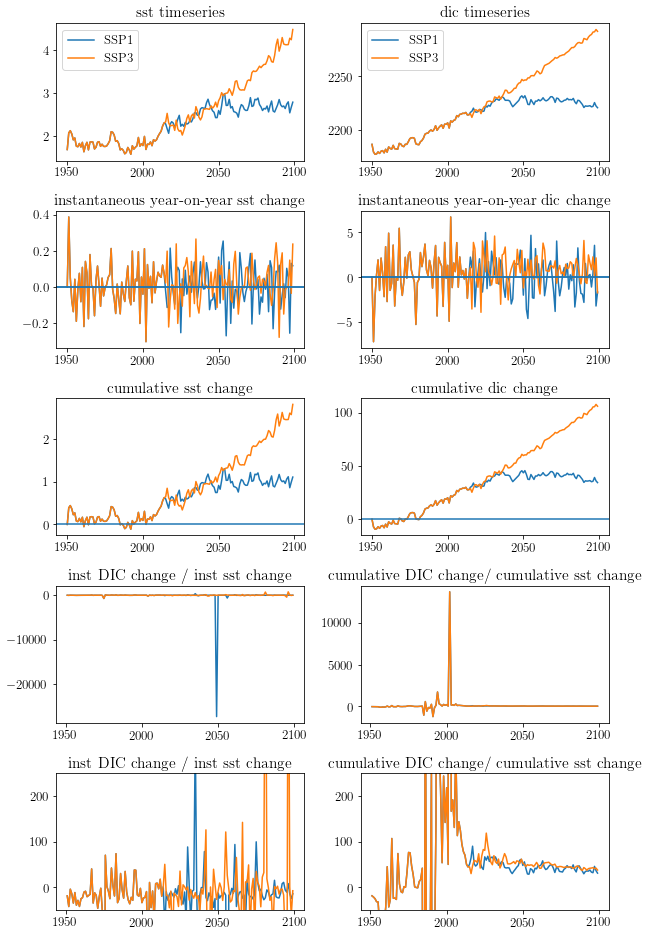

In [217]:
fact = 1.1
fig, axs = plt.subplots(5,2, figsize=(8*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(yrs,sst_1A, label = 'SSP1')
axs[0].plot(yrs,sst_1B, label = 'SSP3')
axs[0].legend(loc = 'best')
axs[1].plot(yrs,medusa_DIC_1A, label = 'SSP1')
axs[1].plot(yrs,medusa_DIC_1B, label = 'SSP3')
axs[1].legend(loc = 'best')


axs[2].plot(yrs,sst_1A_eff)
axs[3].plot(yrs,ts_DIC_effect_medusa_1A)
axs[2].plot(yrs,sst_1B_eff)
axs[3].plot(yrs,ts_DIC_effect_medusa_1B)
axs[2].axhline(y=0)
axs[3].axhline(y=0)

axs[4].plot(yrs,sst_1A_eff_cum)
axs[4].plot(yrs,sst_1B_eff_cum)
axs[5].plot(yrs,ts_DIC_effect_medusa_1A_cum)
axs[5].plot(yrs,ts_DIC_effect_medusa_1B_cum)

axs[6].plot(yrs,ts_DIC_effect_medusa_1A/sst_1A_eff)
axs[6].plot(yrs,ts_DIC_effect_medusa_1B/sst_1B_eff)

axs[7].plot(yrs,ts_DIC_effect_medusa_1A_cum/sst_1A_eff_cum)
axs[7].plot(yrs,ts_DIC_effect_medusa_1B_cum/sst_1B_eff_cum)


axs[8].plot(yrs,ts_DIC_effect_medusa_1A/sst_1A_eff)
axs[8].plot(yrs,ts_DIC_effect_medusa_1B/sst_1B_eff)

axs[9].plot(yrs,ts_DIC_effect_medusa_1A_cum/sst_1A_eff_cum)
axs[9].plot(yrs,ts_DIC_effect_medusa_1B_cum/sst_1B_eff_cum)

axs[2].axhline(y=0)
axs[3].axhline(y=0)
axs[4].axhline(y=0)
axs[5].axhline(y=0)

axs[8].set_ylim([-50,250])
axs[9].set_ylim([-50,250])

tits = ['sst timeseries', 'dic timeseries',\
       'instantaneous year-on-year sst change', \
        'instantaneous year-on-year dic change',
       'cumulative sst change', 'cumulative dic change',\
       'inst DIC change / inst sst change', 'cumulative DIC change/ cumulative sst change',\
       'inst DIC change / inst sst change', 'cumulative DIC change/ cumulative sst change' ]

for i in range(0,10):
    
    axs[i].set_title(tits[i])
    
plt.tight_layout()

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


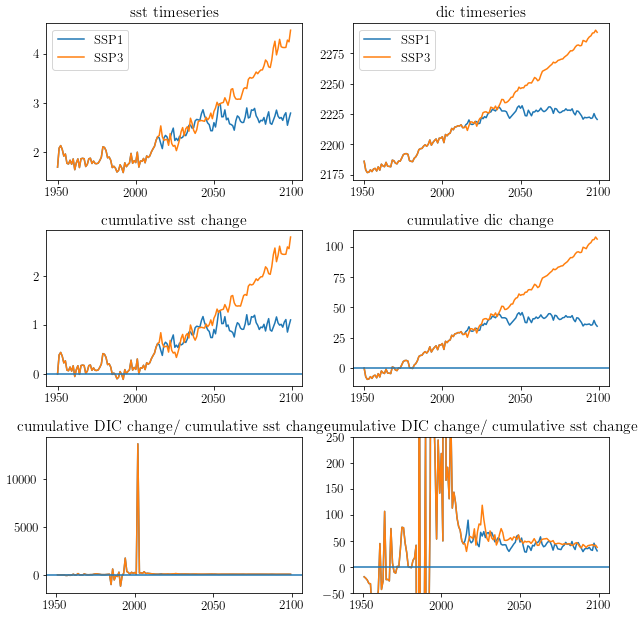

In [218]:
fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(yrs,sst_1A, label = 'SSP1')
axs[0].plot(yrs,sst_1B, label = 'SSP3')
axs[0].legend(loc = 'best')
axs[1].plot(yrs,medusa_DIC_1A, label = 'SSP1')
axs[1].plot(yrs,medusa_DIC_1B, label = 'SSP3')
axs[1].legend(loc = 'best')


axs[2].plot(yrs,sst_1A_eff_cum)
axs[2].plot(yrs,sst_1B_eff_cum)
axs[3].plot(yrs,ts_DIC_effect_medusa_1A_cum)
axs[3].plot(yrs,ts_DIC_effect_medusa_1B_cum)



axs[4].plot(yrs,ts_DIC_effect_medusa_1A_cum/sst_1A_eff_cum)
axs[4].plot(yrs,ts_DIC_effect_medusa_1B_cum/sst_1B_eff_cum)


axs[5].plot(yrs,ts_DIC_effect_medusa_1A_cum/sst_1A_eff_cum)
axs[5].plot(yrs,ts_DIC_effect_medusa_1B_cum/sst_1B_eff_cum)

axs[2].axhline(y=0)
axs[3].axhline(y=0)
axs[4].axhline(y=0)
axs[5].axhline(y=0)

axs[5].set_ylim([-50,250])
axs[5].set_ylim([-50,250])

tits = ['sst timeseries', 'dic timeseries',\
       'cumulative sst change', 'cumulative dic change',\
        'cumulative DIC change/ cumulative sst change',\
       'cumulative DIC change/ cumulative sst change' ]

for i in range(0,6):
    
    axs[i].set_title(tits[i])
    
plt.tight_layout()

## play with the baseline. 

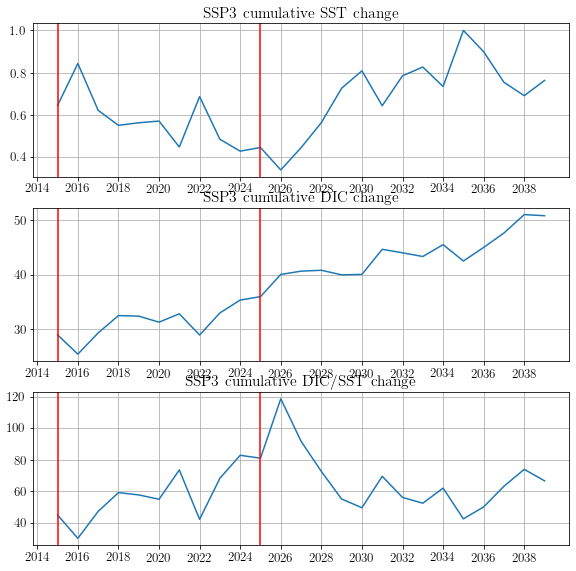

In [220]:
st = 65
en = 90

fig, axs = plt.subplots(3,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(yrs[st:en],sst_1B_eff_cum[st:en])
axs[1].plot(yrs[st:en],ts_DIC_effect_medusa_1B_cum[st:en])
axs[2].plot(yrs[st:en],ts_DIC_effect_medusa_1B_cum[st:en]/sst_1B_eff_cum[st:en])
tits = ['SSP3 cumulative SST change', 'SSP3 cumulative DIC change', 'SSP3 cumulative DIC/SST change']

for i in range(0,3):
    axs[i].axvline(x=2015, color = 'r')
    axs[i].axvline(x=2025, color = 'r')
    axs[i].set_xticks(np.arange(2014,2040,2))
    axs[i].grid()
    axs[i].set_title(tits[i])

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


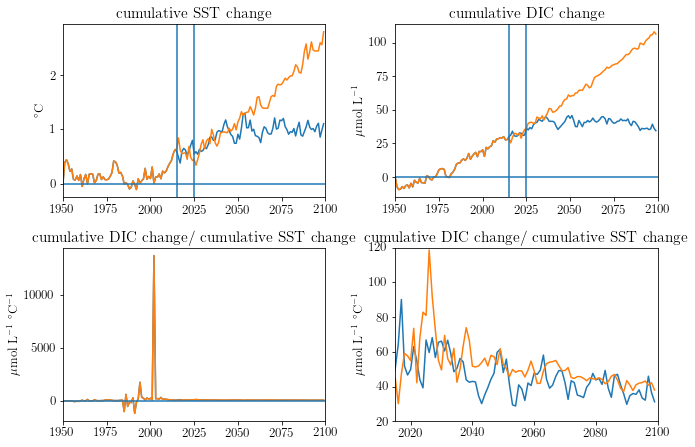

In [221]:
fact = 0.8
fig, axs = plt.subplots(2,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

# axs[0].plot(yrs,sst_1A, label = 'SSP1')
# axs[0].plot(yrs,sst_1B, label = 'SSP3')
# axs[0].legend(loc = 'best')
# axs[1].plot(yrs,medusa_DIC_1A, label = 'SSP1')
# axs[1].plot(yrs,medusa_DIC_1B, label = 'SSP3')
# axs[1].legend(loc = 'best')


axs[0].plot(yrs,sst_1A_eff_cum, label = 'SSP1-2.6')
axs[0].plot(yrs,sst_1B_eff_cum, label = 'SSP3-7.0')
axs[1].plot(yrs,ts_DIC_effect_medusa_1A_cum)
axs[1].plot(yrs,ts_DIC_effect_medusa_1B_cum)





axs[2].plot(yrs,ts_DIC_effect_medusa_1A_cum/sst_1A_eff_cum)
axs[2].plot(yrs,ts_DIC_effect_medusa_1B_cum/sst_1B_eff_cum)


axs[3].plot(yrs,ts_DIC_effect_medusa_1A_cum/sst_1A_eff_cum)
axs[3].plot(yrs,ts_DIC_effect_medusa_1B_cum/sst_1B_eff_cum)
axs[3].set_ylim([-50,250])
axs[3].set_xlim([2015,2100])
axs[3].set_ylim([20,120])

for i in range(0,3):
    axs[i].set_xlim([1950,2100])
axs[1].axhline(y=0)
axs[0].axhline(y=0)
axs[2].axhline(y=0)
axs[3].axhline(y=0)

axs[0].axvline(x=2015); axs[0].axvline(x=2025)
axs[1].axvline(x=2015); axs[1].axvline(x=2025)
# axs[4].axhline(y=0)
# axs[5].axhline(y=0)

# axs[5].set_ylim([-50,250])
# axs[5].set_ylim([-50,250])

tits = ['cumulative SST change', 'cumulative DIC change',\
        'cumulative DIC change/ cumulative SST change',\
       'cumulative DIC change/ cumulative SST change' ]

yax = ['$^{\circ}$C', '$\mu$mol L$^{-1}$','$\mu$mol L$^{-1}$ $^{\circ}$C$^{-1}$', '$\mu$mol L$^{-1}$ $^{\circ}$C$^{-1}$'] 

for i in range(0,4):
    
    axs[i].set_title(tits[i])
    axs[i].set_ylabel(yax[i])
    
plt.tight_layout()

## feedback figures

In [222]:
sot = 2020

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


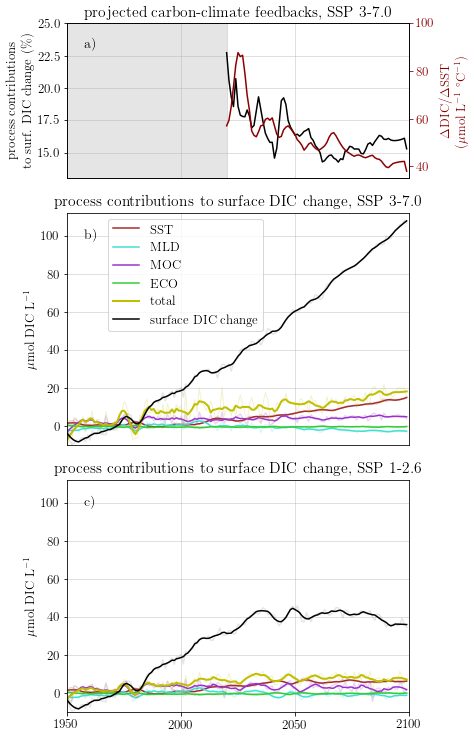

In [223]:
ymi = 13; yma = 25

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fact = 0.95
# Create a figure
fig = plt.figure(figsize=(7*fact, 11*fact))

# Create a GridSpec with 3 rows and 1 column
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 3, 3])

# Add subplots using the GridSpec layout
ax2 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

# Set titles for each subplot for clarity
###

ax4.plot(yrs, ts_T_effect_glodap_1B_cum, color = sst_col, alpha = 0.2)
ax4.plot(yrs, savgol(ts_T_effect_glodap_1B_cum), color = sst_col, label = 'SST')
ax4.plot(yrs, ts_MLD_effect_glodap_1B_cum, color = mld_col, alpha = 0.2)
ax4.plot(yrs, savgol(ts_MLD_effect_glodap_1B_cum), color = mld_col, label = 'MLD')
ax4.plot(yrs, ts_OT_effect_glodap_1B_cum, color = ot_col, alpha = 0.2 )
ax4.plot(yrs, savgol(ts_OT_effect_glodap_1B_cum), color = ot_col, label = 'MOC')
ax4.plot(yrs, ts_ECO_effect_glodap_1B_cum, color = eco_col, alpha = 0.2 )
ax4.plot(yrs, savgol(ts_ECO_effect_glodap_1B_cum), color = eco_col, label = 'ECO')
ts_tot_effect_1B_cum_glodap = ts_T_effect_glodap_1B_cum + ts_MLD_effect_glodap_1B_cum + \
ts_OT_effect_glodap_1B_cum + ts_ECO_effect_glodap_1B_cum
ax4.plot(yrs, ts_tot_effect_1B_cum, color = tot_col, alpha = 0.2, linewidth = 1)
ax4.plot(yrs, savgol(ts_tot_effect_1B_cum), color = tot_col, linewidth = 2, label = 'total')
ax4.plot(yrs, ts_DIC_effect_medusa_1B_cum, color = 'grey', alpha = 0.2,  )
ax4.plot(yrs, savgol(ts_DIC_effect_medusa_1B_cum), 'k', alpha = 1, label = 'surface DIC change')

ax3.plot(yrs, ts_T_effect_glodap_1A_cum, color = sst_col, alpha = 0.2)
ax3.plot(yrs, savgol(ts_T_effect_glodap_1A_cum), color = sst_col, label = 'DIC change due to SST')
ax3.plot(yrs, ts_MLD_effect_glodap_1A_cum, color = mld_col, alpha = 0.2)
ax3.plot(yrs, savgol(ts_MLD_effect_glodap_1A_cum), color = mld_col, label = 'DIC change due to MLD')
ax3.plot(yrs, ts_OT_effect_glodap_1A_cum, color = ot_col, alpha = 0.2 )
ax3.plot(yrs, savgol(ts_OT_effect_glodap_1A_cum), color = ot_col, label = 'DIC change due to MOC')
ax3.plot(yrs, ts_ECO_effect_glodap_1A_cum, color = eco_col, alpha = 0.2 )
ax3.plot(yrs, savgol(ts_ECO_effect_glodap_1A_cum), color = eco_col, label = 'DIC change cumulative')
ts_tot_effect_1A_cum = ts_T_effect_glodap_1A_cum + ts_MLD_effect_glodap_1A_cum + \
ts_OT_effect_glodap_1A_cum + ts_ECO_effect_glodap_1A_cum
ax3.plot(yrs, ts_tot_effect_1A_cum, color = tot_col, alpha = 0.2, linewidth = 1)
ax3.plot(yrs, savgol(ts_tot_effect_1A_cum), color = tot_col, linewidth = 2)
ax3.plot(yrs, ts_DIC_effect_medusa_1A_cum, color = 'grey', alpha = 0.2,  label = 'DIC change medusa, 1A')
ax3.plot(yrs, savgol(ts_DIC_effect_medusa_1A_cum), 'k', alpha = 1, label = 'DIC change cumulative, 1A')

####### code for proportions!!!
glodap_prop = ts_tot_effect_1B_cum_glodap/ts_DIC_effect_medusa_1B_cum
glodap_propc = zbastli(glodap_prop,sot,2000)*100
ax2.plot(yrs,glodap_propc, color = 'k')

axs2b = ax2.twinx()
dicpert = ts_DIC_effect_medusa_1B_cum/sst_1B_eff_cum
dicpertc = zbastli(dicpert,sot,2000)
ax2.fill_betweenx([-200, 200], 1950, sot, color='grey', alpha=0.2)
ax2.set_ylim([ymi,yma])
axs2b.plot(yrs,dicpertc, color ='darkred',label = 'dic/T')
axs2b.set_ylim([35,100])
axs2b.set_ylabel('$\Delta$DIC/$\Delta$SST \n ($\mu$mol L$^{-1}$ $^{\circ}$C$^{-1}$)', color='darkred')
axs2b.tick_params(axis='y', colors='darkred')
axs2b.yaxis.label.set_color('darkred')
####### code for proportions!!!


ax2.set_xlim([1950,2100])
ax3.set_xlim([1950,2100])
ax4.set_xlim([1950,2100])
ax2.set_xticks(np.arange(1950,2150,50))
ax3.set_xticks(np.arange(1950,2150,50))
ax4.set_xticks(np.arange(1950,2150,50))
ax2.set_xticklabels([])
ax4.set_xticklabels([])
ax2.tick_params(axis='x', colors='red', size=0.1)
ax4.tick_params(axis='x', colors='red', size=0.1)

ax4.set_ylabel('$\mu$mol DIC L$^{-1}$')
ax3.set_ylabel('$\mu$mol DIC L$^{-1}$')
ax2.set_ylabel('process contributions \n to surf. DIC change  ($\%$)')

ax4.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)
ax3.grid(alpha = 0.5)

ax2.set_title('projected carbon-climate feedbacks, SSP 3-7.0')
ax3.set_title('process contributions to surface DIC change, SSP 1-2.6')
ax4.set_title('process contributions to surface DIC change, SSP 3-7.0')

fs = 14
ax2.text(0.05, 0.85, 'a)', fontsize=fs, fontweight='bold', transform=ax2.transAxes)
ax4.text(0.05, 0.89,  'b)', fontsize=fs, fontweight='bold', transform=ax4.transAxes)#nsform=fig.transFigure)
ax3.text(0.05, 0.89, 'c)', fontsize=fs, fontweight='bold', transform=ax3.transAxes)

ax4.legend(loc = [0.12,0.49])

ax2.tick_params(axis='x', colors='red', size=0.1)
ax4.tick_params(axis='x', colors='red', size=0.1)

# Adjust layout
plt.tight_layout()

ax4.set_ylim([-10,112])
ax3.set_ylim([-10,112])

# Display the plot
plt.show()
fig.savefig(f'./figs/fig5_feedbacksfrom{yrsot}.png')

### supp. fig.

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide


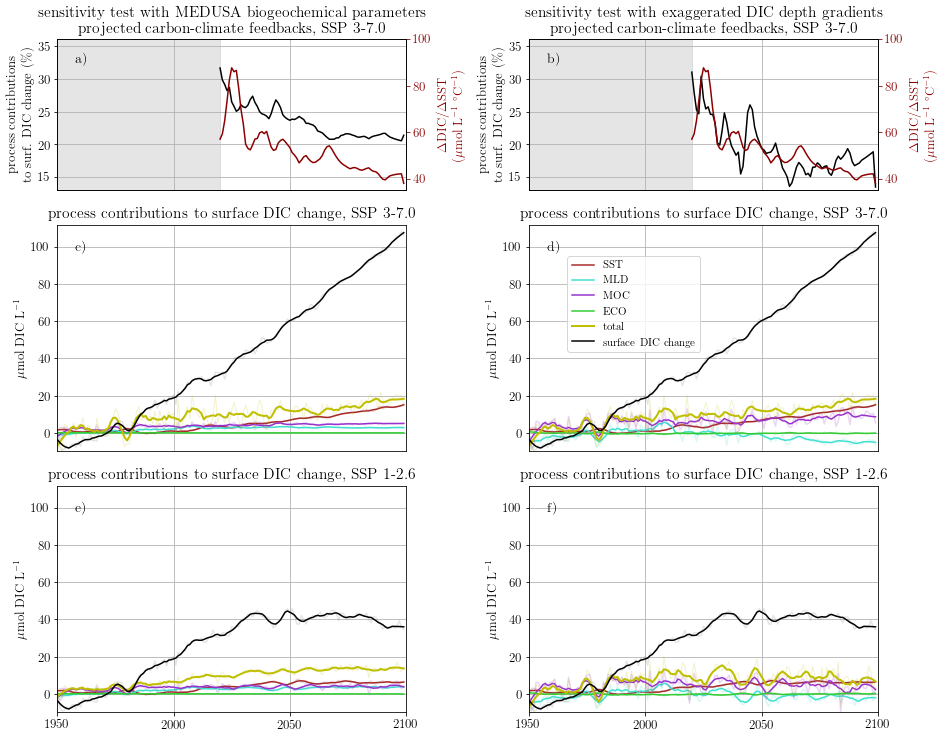

In [224]:
ymi = 13; yma = 36

#sot = yrstart-1950
fig = plt.figure(figsize=(14*fact, 11*fact))

# Create a GridSpec with 3 rows and 2 columns
gs = gridspec.GridSpec(3, 2, height_ratios=[2, 3, 3])

# Add subplots using the GridSpec layout
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

# Set titles for each subplot for clarity
ax3.set_title('aRow 2, Col 1 (Same height as Row 3)')
ax3.plot(yrs, ts_T_effect_medusa_1B_cum, color = sst_col, alpha = 0.2)
ax3.plot(yrs, savgol(ts_T_effect_medusa_1B_cum), color = sst_col, label = 'SST')
ax3.plot(yrs, ts_MLD_effect_medusa_1B_cum, color = mld_col, alpha = 0.2)
ax3.plot(yrs, savgol(ts_MLD_effect_medusa_1B_cum), color = mld_col, label = 'MLD')
ax3.plot(yrs, ts_OT_effect_medusa_1B_cum, color = ot_col, alpha = 0.2 )
ax3.plot(yrs, savgol(ts_OT_effect_medusa_1B_cum), color = ot_col, label = 'MOC')
ax3.plot(yrs, ts_ECO_effect_medusa_1B_cum, color = eco_col, alpha = 0.2 )
ax3.plot(yrs, savgol(ts_ECO_effect_medusa_1B_cum), color = eco_col, label = 'ECO')
ts_tot_effect_1B_cum_medusa = ts_T_effect_medusa_1B_cum + ts_MLD_effect_medusa_1B_cum + \
ts_OT_effect_medusa_1B_cum + ts_ECO_effect_medusa_1B_cum
ax3.plot(yrs, ts_tot_effect_1B_cum, color = tot_col, alpha = 0.2, linewidth = 1)
ax3.plot(yrs, savgol(ts_tot_effect_1B_cum), color = tot_col, linewidth = 2, label = 'total')
ax3.plot(yrs, ts_DIC_effect_medusa_1B_cum, color = 'grey', alpha = 0.2,  )
ax3.plot(yrs, savgol(ts_DIC_effect_medusa_1B_cum), 'k', alpha = 1, label = 'surface DIC change')

ax5.set_title('aRow 3, Col 1 (Same height as Row 2)')
ax5.plot(yrs, ts_T_effect_medusa_1A_cum, color = sst_col, alpha = 0.2)
ax5.plot(yrs, savgol(ts_T_effect_medusa_1A_cum), color = sst_col, label = 'DIC change due to SST')
ax5.plot(yrs, ts_MLD_effect_medusa_1A_cum, color = mld_col, alpha = 0.2)
ax5.plot(yrs, savgol(ts_MLD_effect_medusa_1A_cum), color = mld_col, label = 'DIC change due to MLD')
ax5.plot(yrs, ts_OT_effect_medusa_1A_cum, color = ot_col, alpha = 0.2 )
ax5.plot(yrs, savgol(ts_OT_effect_medusa_1A_cum), color = ot_col, label = 'DIC change due to MOC')
ax5.plot(yrs, ts_ECO_effect_medusa_1A_cum, color = eco_col, alpha = 0.2 )
ax5.plot(yrs, savgol(ts_ECO_effect_medusa_1A_cum), color = eco_col, label = 'DIC change cumulative')
ts_tot_effect_1A_cum = ts_T_effect_medusa_1A_cum + ts_MLD_effect_medusa_1A_cum + \
ts_OT_effect_medusa_1A_cum + ts_ECO_effect_medusa_1A_cum
ax5.plot(yrs, ts_tot_effect_1A_cum, color = tot_col, alpha = 0.2, linewidth = 1)
ax5.plot(yrs, savgol(ts_tot_effect_1A_cum), color = tot_col, linewidth = 2)
ax5.plot(yrs, ts_DIC_effect_medusa_1A_cum, color = 'grey', alpha = 0.2,  label = 'DIC change medusa, 1A')
ax5.plot(yrs, savgol(ts_DIC_effect_medusa_1A_cum), 'k', alpha = 1, label = 'DIC change cumulative, 1A')


####### code for proportions!!!
####### code for proportions!!!
glodapvul_prop = ts_tot_effect_1B_cum_glodapvul/ts_DIC_effect_medusa_1B_cum
glodapvul_propc = zbastli(glodapvul_prop,sot,2000)*100
ax2.plot(yrs,glodapvul_propc, color = 'k')

axs2b = ax2.twinx()
dicpert = ts_DIC_effect_medusa_1B_cum/sst_1B_eff_cum
dicpertc = zbastli(dicpert,sot,2000)

ax2.fill_betweenx([-200, 200], 1950, sot, color='grey', alpha=0.2)
ax2.set_ylim([ymi,yma])
axs2b.plot(yrs,dicpertc, color ='darkred',label = 'dic/T')
axs2b.set_ylim([35,100])
axs2b.set_ylabel('$\Delta$DIC/$\Delta$SST \n ($\mu$mol L$^{-1}$ $^{\circ}$C$^{-1}$)', color='darkred')
axs2b.tick_params(axis='y', colors='darkred')
axs2b.yaxis.label.set_color('darkred')
####### code for proportions!!!

####### code for proportions!!!
medusa_prop = ts_tot_effect_1B_cum_medusa/ts_DIC_effect_medusa_1B_cum
medusa_propc = zbastli(medusa_prop,sot,2000)*100
ax1.plot(yrs,medusa_propc, color = 'k')

axs1b = ax1.twinx()
dicpert = ts_DIC_effect_medusa_1B_cum/sst_1B_eff_cum
dicpertc = zbastli(dicpert,sot,2000)
ax1.fill_betweenx([-200, 200], 1950, sot, color='grey', alpha=0.2)
ax1.set_ylim([ymi,yma])
axs1b.plot(yrs,dicpertc, color ='darkred',label = 'dic/T')
axs1b.set_ylim([35,100])
axs1b.set_ylabel('$\Delta$DIC/$\Delta$SST \n ($\mu$mol L$^{-1}$ $^{\circ}$C$^{-1}$)', color='darkred')
axs1b.tick_params(axis='y', colors='darkred')
axs1b.yaxis.label.set_color('darkred')


ax4.set_title('Row 2, Col 2 (Same height as Row 3)')
ax4.plot(yrs, ts_T_effect_glodapvul_1B_cum, color = sst_col, alpha = 0.2)
ax4.plot(yrs, savgol(ts_T_effect_glodapvul_1B_cum), color = sst_col, label = 'SST')
ax4.plot(yrs, ts_MLD_effect_glodapvul_1B_cum, color = mld_col, alpha = 0.2)
ax4.plot(yrs, savgol(ts_MLD_effect_glodapvul_1B_cum), color = mld_col, label = 'MLD')
ax4.plot(yrs, ts_OT_effect_glodapvul_1B_cum, color = ot_col, alpha = 0.2 )
ax4.plot(yrs, savgol(ts_OT_effect_glodapvul_1B_cum), color = ot_col, label = 'MOC')
ax4.plot(yrs, ts_ECO_effect_glodapvul_1B_cum, color = eco_col, alpha = 0.2 )
ax4.plot(yrs, savgol(ts_ECO_effect_glodapvul_1B_cum), color = eco_col, label = 'ECO')
ts_tot_effect_1B_cum_glodapvul = ts_T_effect_glodapvul_1B_cum + ts_MLD_effect_glodapvul_1B_cum + \
ts_OT_effect_glodapvul_1B_cum + ts_ECO_effect_glodapvul_1B_cum
ax4.plot(yrs, ts_tot_effect_1B_cum, color = tot_col, alpha = 0.2, linewidth = 1)
ax4.plot(yrs, savgol(ts_tot_effect_1B_cum), color = tot_col, linewidth = 2, label = 'total')
ax4.plot(yrs, ts_DIC_effect_medusa_1B_cum, color = 'grey', alpha = 0.2,  )
ax4.plot(yrs, savgol(ts_DIC_effect_medusa_1B_cum), 'k', alpha = 1, label = 'surface DIC change')

ax6.set_title('Row 3, Col 2 (Same height as Row 2)')
ax6.plot(yrs, ts_T_effect_glodapvul_1A_cum, color = sst_col, alpha = 0.2)
ax6.plot(yrs, savgol(ts_T_effect_glodapvul_1A_cum), color = sst_col, label = 'DIC change due to SST')
ax6.plot(yrs, ts_MLD_effect_glodapvul_1A_cum, color = mld_col, alpha = 0.2)
ax6.plot(yrs, savgol(ts_MLD_effect_glodapvul_1A_cum), color = mld_col, label = 'DIC change due to MLD')
ax6.plot(yrs, ts_OT_effect_glodapvul_1A_cum, color = ot_col, alpha = 0.2 )
ax6.plot(yrs, savgol(ts_OT_effect_glodapvul_1A_cum), color = ot_col, label = 'DIC change due to MOC')
ax6.plot(yrs, ts_ECO_effect_glodapvul_1A_cum, color = eco_col, alpha = 0.2 )
ax6.plot(yrs, savgol(ts_ECO_effect_glodapvul_1A_cum), color = eco_col, label = 'DIC change cumulative')
ts_tot_effect_1A_cum = ts_T_effect_glodapvul_1A_cum + ts_MLD_effect_glodapvul_1A_cum + \
ts_OT_effect_glodapvul_1A_cum + ts_ECO_effect_glodapvul_1A_cum
ax6.plot(yrs, ts_tot_effect_1A_cum, color = tot_col, alpha = 0.2, linewidth = 1)
ax6.plot(yrs, savgol(ts_tot_effect_1A_cum), color = tot_col, linewidth = 2)
ax6.plot(yrs, ts_DIC_effect_medusa_1A_cum, color = 'grey', alpha = 0.2,  label = 'DIC change medusa, 1A')
ax6.plot(yrs, savgol(ts_DIC_effect_medusa_1A_cum), 'k', alpha = 1, label = 'DIC change cumulative, 1A')


ax1.set_xlim([1950,2100])
ax2.set_xlim([1950,2100])
ax1.set_ylim([ymi,yma])
ax2.set_ylim([ymi,yma])
ax3.set_xlim([1950,2100])
ax4.set_xlim([1950,2100])
ax5.set_xlim([1950,2100])
ax6.set_xlim([1950,2100])


ax1.text(0.05, 0.85, 'a)', fontsize=fs, fontweight='bold', transform=ax1.transAxes)
ax2.text(0.05, 0.85, 'b)', fontsize=fs, fontweight='bold', transform=ax2.transAxes)
ax3.text(0.05, 0.89, 'c)', fontsize=fs, fontweight='bold', transform=ax3.transAxes)
ax4.text(0.05, 0.89, 'd)', fontsize=fs, fontweight='bold', transform=ax4.transAxes)
ax5.text(0.05, 0.89, 'e)', fontsize=fs, fontweight='bold', transform=ax5.transAxes)
ax6.text(0.05, 0.89, 'f)', fontsize=fs, fontweight='bold', transform=ax6.transAxes)

ax4.legend(loc = [0.11,0.44], fontsize = 11)
ax3.set_ylim([-10,112])
ax4.set_ylim([-10,112])
ax5.set_ylim([-10,112])
ax6.set_ylim([-10,112])

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])


###
ax1.set_xlim([1950,2100])
ax2.set_xlim([1950,2100])
ax3.set_xlim([1950,2100])
ax4.set_xlim([1950,2100])
ax5.set_xlim([1950,2100])
ax6.set_xlim([1950,2100])
ax1.set_xticks(np.arange(1950,2150,50))
ax2.set_xticks(np.arange(1950,2150,50))
ax3.set_xticks(np.arange(1950,2150,50))
ax4.set_xticks(np.arange(1950,2150,50))
ax5.set_xticks(np.arange(1950,2150,50))
ax6.set_xticks(np.arange(1950,2150,50))
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax1.tick_params(axis='x', colors='red', size=0.1)
ax2.tick_params(axis='x', colors='red', size=0.1)
ax3.tick_params(axis='x', colors='red', size=0.1)
ax4.tick_params(axis='x', colors='red', size=0.1)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()



ax2.set_title('sensitivity test with exaggerated DIC depth gradients \n projected carbon-climate feedbacks, SSP 3-7.0')
ax4.set_title('process contributions to surface DIC change, SSP 3-7.0')
ax6.set_title('process contributions to surface DIC change, SSP 1-2.6')

ax1.set_title('sensitivity test with MEDUSA biogeochemical parameters \n projected carbon-climate feedbacks, SSP 3-7.0')
ax3.set_title('process contributions to surface DIC change, SSP 3-7.0')
ax5.set_title('process contributions to surface DIC change, SSP 1-2.6')


ax1.set_ylabel('process contributions \n to surf. DIC change  ($\%$)')
ax2.set_ylabel('process contributions \n to surf. DIC change  ($\%$)')
ax3.set_ylabel('$\mu$mol DIC L$^{-1}$')
ax4.set_ylabel('$\mu$mol DIC L$^{-1}$')
ax5.set_ylabel('$\mu$mol DIC L$^{-1}$')
ax6.set_ylabel('$\mu$mol DIC L$^{-1}$')

plt.tight_layout()

# Display the plot
plt.show()

## plot to test effect of savgol filters

TL;DR it doesn't matter how you do them

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2

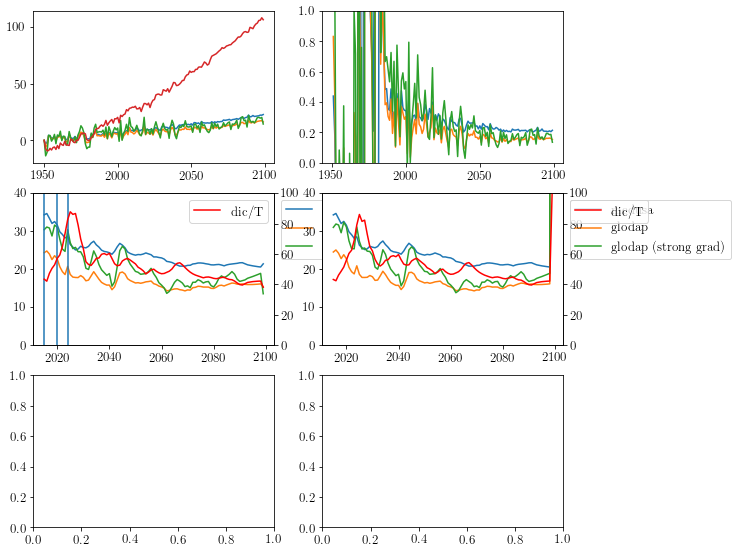

In [225]:


syr = 2000
sot = 2015


fig, axs = plt.subplots(3,2, figsize=(10*fact, 10*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(yrs, ts_tot_effect_1B_cum_medusa, label = 'medusa')
axs[0].plot(yrs,ts_tot_effect_1B_cum_glodap, label = 'glodap')
axs[0].plot(yrs,ts_tot_effect_1B_cum_glodapvul, label = 'glodapvul')
axs[0].plot(yrs,ts_DIC_effect_medusa_1B_cum, label = 'glodap')

axs[1].plot(yrs,ts_tot_effect_1B_cum_medusa/ts_DIC_effect_medusa_1B_cum, label = 'medusa')
axs[1].plot(yrs,ts_tot_effect_1B_cum_glodap/ts_DIC_effect_medusa_1B_cum, label = 'glodap')
axs[1].plot(yrs,ts_tot_effect_1B_cum_glodapvul/ts_DIC_effect_medusa_1B_cum, label = 'glodapvul')
axs[1].set_ylim([0,1])

medusa_prop = ts_tot_effect_1B_cum_medusa/ts_DIC_effect_medusa_1B_cum
medusa_propc = zbastli(medusa_prop,sot,2000)*100
glodap_prop = ts_tot_effect_1B_cum_glodap/ts_DIC_effect_medusa_1B_cum
glodap_propc = zbastli(glodap_prop,sot,2000)*100
glodapvul_prop = ts_tot_effect_1B_cum_glodapvul/ts_DIC_effect_medusa_1B_cum
glodapvul_propc = zbastli(glodapvul_prop,sot,2000)*100
axs[2].plot(yrs,medusa_propc, label = 'medusa')
axs[2].plot(yrs,glodap_propc, label = 'glodap')
axs[2].plot(yrs,glodapvul_propc, label = 'glodap (strong grad)')
axs[2].set_ylim([0.0,40])
axs2b = axs[2].twinx()
dicpert = ts_DIC_effect_medusa_1B_cum/sst_1B_eff_cum
dicpertc = zbastli(dicpert,sot,2000)
axs2b.plot(yrs,dicpertc, color ='r',label = 'dic/T')
axs2b.set_ylim([0,100])
axs2b.legend(bbox_to_anchor = [1,1])
axs[2].legend(bbox_to_anchor = [1,1])

axs[2].axvline(x=2015)
axs[2].axvline(x=2020)
axs[2].axvline(x=2024)


####
medusa_prop = ts_tot_effect_1B_cum_medusa/ts_DIC_effect_medusa_1B_cum
medusa_propc = zbastli_zvlast(ts_tot_effect_1B_cum_medusa,ts_DIC_effect_medusa_1B_cum,sot,2000)*100
glodap_prop = ts_tot_effect_1B_cum_glodap/ts_DIC_effect_medusa_1B_cum
glodap_propc = zbastli_zvlast(ts_tot_effect_1B_cum_glodap,ts_DIC_effect_medusa_1B_cum,sot,2000)*100
glodapvul_prop = ts_tot_effect_1B_cum_glodapvul/ts_DIC_effect_medusa_1B_cum
glodapvul_propc = zbastli_zvlast(ts_tot_effect_1B_cum_glodapvul,ts_DIC_effect_medusa_1B_cum,sot,2000)*100
axs[3].plot(yrs,medusa_propc, label = 'medusa')
axs[3].plot(yrs,glodap_propc, label = 'glodap')
axs[3].plot(yrs,glodapvul_propc, label = 'glodap (strong grad)')
axs[3].set_ylim([0.0,40])
axs3b = axs[3].twinx()
dicpert = ts_DIC_effect_medusa_1B_cum/sst_1B_eff_cum
dicpertc = zbastli_zvlast(ts_DIC_effect_medusa_1B_cum,sst_1B_eff_cum,sot,2000)
axs3b.plot(yrs,dicpertc, color ='r',label = 'dic/T')
axs3b.set_ylim([0,100])
axs3b.legend(bbox_to_anchor = [1,1])
axs[3].legend(bbox_to_anchor = [1,1])


#axs[1].plot(yrs,ts_DIC_effect_medusa_1B_cum/ts_DIC_effect_medusa_1B_cum, label = 'glodap')